In [1]:
import pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score
import joblib

# load data & model (adjust filenames if different)
X_val = pd.read_csv("data/X_val.csv")
y_val = pd.read_csv("data/y_val.csv").squeeze()   # series

final_model = joblib.load("models/final_day5_bestmodel.pkl")

# predicted probabilities and labels (positive class prob)
y_proba = final_model.predict_proba(X_val)[:,1]
y_pred = (y_proba >= 0.5).astype(int)  # you can change threshold later


In [2]:
#Group fairness: approval rates & disparate impactv

def approval_rates_by_group(X, y_pred, group_col):
    df = pd.DataFrame({group_col: X[group_col].astype(str), 'pred': y_pred})
    rates = df.groupby(group_col)['pred'].mean().sort_values(ascending=False)
    counts = df.groupby(group_col)['pred'].count()
    return pd.concat([counts, rates.rename('approval_rate')], axis=1)

# Example: gender
print(approval_rates_by_group(X_val, y_pred, 'person_gender'))


               pred  approval_rate
person_gender                     
female         1366       0.229868
male           1634       0.185435


In [3]:
def disparate_impact(X, y_pred, group_col, protected, reference):
    rates = approval_rates_by_group(X, y_pred, group_col)['approval_rate']
    return rates.loc[protected] / rates.loc[reference]

# Example:
# disparate_impact(X_val, y_pred, 'person_gender', protected='Female', reference='Male')


In [4]:
#Error-rate parity: FPR / FNR by group


from sklearn.metrics import confusion_matrix

def group_error_rates(X, y_true, y_pred, group_col):
    rows = []
    for g, sub in X.groupby(group_col).groups.items():
        idx = list(sub)
        yt = y_true.iloc[idx]
        yp = pd.Series(y_pred, index=X.index).iloc[idx]
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
        fpr = fp / (fp + tn) if (fp + tn)>0 else np.nan
        fnr = fn / (fn + tp) if (fn + tp)>0 else np.nan
        rows.append((g, len(idx), fpr, fnr, tp/(tp+fp+1e-9)))
    return pd.DataFrame(rows, columns=[group_col, 'n', 'FPR', 'FNR', 'precision'])

print(group_error_rates(X_val, y_val, y_pred, 'person_gender'))


  person_gender     n       FPR       FNR  precision
0        female  1366  0.038278  0.146417   0.872611
1          male  1634  0.020062  0.180473   0.914191


In [5]:
#Performance by subgroup: AUC, precision, recall


def subgroup_performance(X, y_true, y_proba, group_col):
    rows=[]
    for g, idxs in X.groupby(group_col).groups.items():
        idx = list(idxs)
        try:
            auc = roc_auc_score(y_true.iloc[idx], y_proba[idx])
        except ValueError:
            auc = np.nan
        prec = precision_score(y_true.iloc[idx], (y_proba[idx]>=0.5).astype(int), zero_division=0)
        rec  = recall_score(y_true.iloc[idx], (y_proba[idx]>=0.5).astype(int), zero_division=0)
        rows.append((g, len(idx), auc, prec, rec))
    return pd.DataFrame(rows, columns=[group_col,'n','AUC','precision','recall']).sort_values('AUC', ascending=False)

print(subgroup_performance(X_val, y_val, y_proba, 'person_gender'))
print(subgroup_performance(X_val, y_val, y_proba, 'person_education'))


  person_gender     n       AUC  precision    recall
0        female  1366  0.982039   0.872611  0.853583
1          male  1634  0.981096   0.914191  0.819527
  person_education    n       AUC  precision    recall
2        Doctorate   64  0.989130   0.937500  0.833333
3      High School  828  0.984256   0.874286  0.854749
1         Bachelor  867  0.982834   0.904762  0.849162
0        Associate  831  0.981162   0.901734  0.838710
4           Master  410  0.975166   0.882353  0.773196


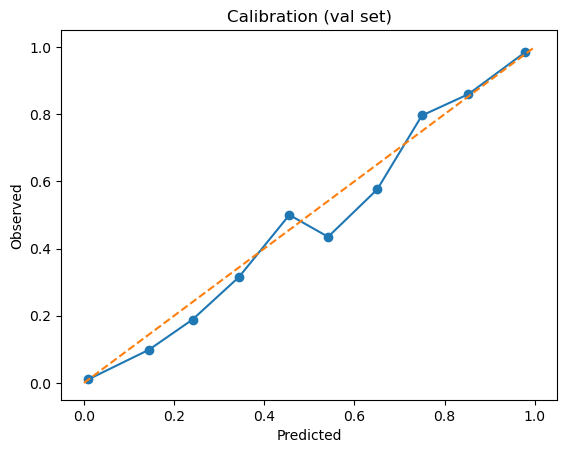

Brier: 0.04150105946349585


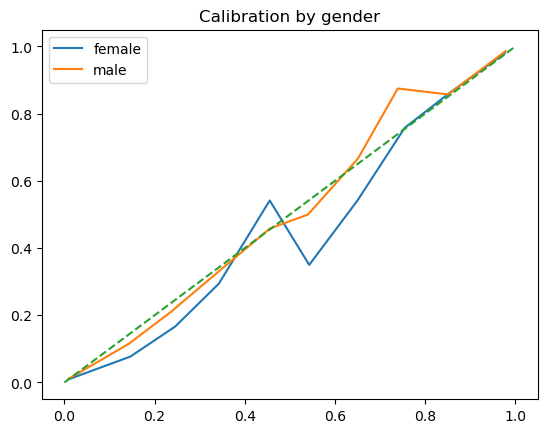

In [8]:
#Calibration checks (are probabilities meaningful?)


from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss

# global
prob_true, prob_pred = calibration_curve(y_val, y_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--'); plt.xlabel('Predicted'); plt.ylabel('Observed'); plt.title('Calibration (val set)'); plt.show()
print("Brier:", brier_score_loss(y_val, y_proba))

# per-group example
for g, idxs in X_val.groupby('person_gender').groups.items():
    idx=list(idxs)
    if len(idx)>50:
        pt, pp = calibration_curve(y_val.iloc[idx], y_proba[idx], n_bins=10)
        plt.plot(pp, pt, label=str(g))
plt.plot([0,1],[0,1],'--'); plt.legend(); plt.title('Calibration by gender'); plt.show()


AUC mean, std: 0.9816079807792691 0.002156580754463212


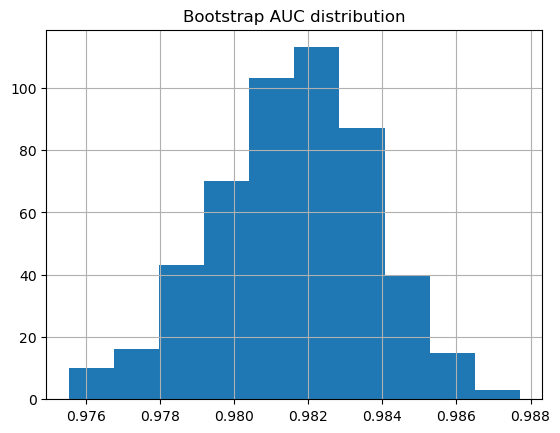

In [9]:
#Robustness checks — Bootstrapped AUC (stability)

def bootstrap_auc(y_true, y_proba, n_boot=1000):
    rng = np.random.RandomState(42)
    aucs=[]
    n=len(y_true)
    for i in range(n_boot):
        idx = rng.randint(0, n, n)
        try:
            aucs.append(roc_auc_score(y_true.iloc[idx], y_proba[idx]))
        except:
            aucs.append(np.nan)
    return np.array(aucs)

aucs = bootstrap_auc(y_val.reset_index(drop=True), y_proba, n_boot=500)
print("AUC mean, std:", np.nanmean(aucs), np.nanstd(aucs))
pd.Series(aucs).hist(); plt.title('Bootstrap AUC distribution'); plt.show()


In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def eval_drop_cols_neutral(X_val, drop_cols, final_model, y_true):
    """
    Simulate dropping features by replacing numeric features with median
    and categorical with mode (most frequent). Then call pipeline.predict_proba.
    """
    X_mod = X_val.copy()

    # find numeric vs categorical from dataframe types
    num_cols = X_mod.select_dtypes(include='number').columns.tolist()
    cat_cols = X_mod.select_dtypes(include=['object','category']).columns.tolist()

    for col in drop_cols:
        if col not in X_mod.columns:
            print(f"Warning: {col} not in X_val columns — skipping.")
            continue
        if col in num_cols:
            median_val = X_mod[col].median()
            X_mod[col] = median_val
        else:
            # categorical: replace with mode (most frequent)
            mode_val = X_mod[col].mode(dropna=True)
            mode_val = mode_val.iloc[0] if len(mode_val)>0 else "Missing"
            X_mod[col] = mode_val

    probs = final_model.predict_proba(X_mod)[:,1]
    return roc_auc_score(y_true, probs)


In [17]:
#Feature ablation (remove top features and re-evaluate)

# assume feat_names_transformed is array of transformed feature names and shap_values computed earlier
# but for simplicity we use model's feature_importances_ if accessible
model_xgb = final_model.named_steps['model']
try:
    importances = model_xgb.feature_importances_
    # find top k indexes
    top_idx = np.argsort(importances)[-5:][::-1]   # top 5
except:
    top_idx = []

# function to evaluate AUC when dropping a set of columns from original X (before preprocess)
def eval_drop_cols(drop_cols):
    X_mod = X_val.drop(columns=drop_cols)
    probs = final_model.predict_proba(X_mod)[:,1]
    return roc_auc_score(y_val, probs)

# Example: drop 'loan_percent_income' and 'credit_score'
print("AUC original:", roc_auc_score(y_val, y_proba))
print("AUC drop loan_percent_income:", eval_drop_cols(['loan_percent_income']))
print("AUC drop credit_score:", eval_drop_cols(['credit_score']))


AUC original: 0.9816045566302094


ValueError: columns are missing: {'loan_percent_income'}

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

def eval_drop_cols_neutral(X_val, drop_cols, final_model, y_true):
    """
    Simulate dropping features by replacing numeric features with median
    and categorical with mode (most frequent). Then call pipeline.predict_proba.
    """
    X_mod = X_val.copy()

    # find numeric vs categorical from dataframe types
    num_cols = X_mod.select_dtypes(include='number').columns.tolist()
    cat_cols = X_mod.select_dtypes(include=['object','category']).columns.tolist()

    for col in drop_cols:
        if col not in X_mod.columns:
            print(f"Warning: {col} not in X_val columns — skipping.")
            continue
        if col in num_cols:
            median_val = X_mod[col].median()
            X_mod[col] = median_val
        else:
            # categorical: replace with mode (most frequent)
            mode_val = X_mod[col].mode(dropna=True)
            mode_val = mode_val.iloc[0] if len(mode_val)>0 else "Missing"
            X_mod[col] = mode_val

    probs = final_model.predict_proba(X_mod)[:,1]
    return roc_auc_score(y_true, probs)


In [18]:
print("AUC original:", roc_auc_score(y_val, y_proba))
print("AUC neutralize loan_percent_income:",
      eval_drop_cols_neutral(X_val, ['loan_percent_income'], final_model, y_val))
print("AUC neutralize credit_score:",
      eval_drop_cols_neutral(X_val, ['credit_score'], final_model, y_val))


AUC original: 0.9816045566302094
AUC neutralize loan_percent_income: 0.970651816695069
AUC neutralize credit_score: 0.9800670115555716


In [15]:
from sklearn.inspection import permutation_importance
import numpy as np

# final_model must be your pipeline (preprocess + xgb)
result = permutation_importance(
    final_model, X_val, y_val,
    scoring='roc_auc',
    n_repeats=20, random_state=42, n_jobs=-1
)

# result.importances_mean aligned with X_val.columns order
perm_imp = pd.DataFrame({
    'feature': X_val.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=False)

perm_imp.head(20)


,feature,importance_mean,importance_std
12,previous_loan_defaults_on_file,0.267397,0.012661
5,person_home_ownership,0.035136,0.003159
8,loan_int_rate,0.022134,0.002227
9,loan_percent_income,0.017648,0.001569
3,person_income,0.017346,0.001103
7,loan_intent,0.008660,0.000914
11,credit_score,0.003090,0.000633
15,payment_to_income,0.002722,0.000728
6,loan_amnt,0.001524,0.000275
14,monthly_payment_est,0.000980,0.000244


In [20]:
#Noise injection (simulate measurement error)

def add_noise_and_eval(col, sigma=0.1):
    X_noisy = X_val.copy()
    X_noisy[col] = X_noisy[col] * (1 + np.random.normal(0, sigma, size=len(X_noisy)))
    probs = final_model.predict_proba(X_noisy)[:,1]
    return roc_auc_score(y_val, probs)

print("AUC with 10% income noise:", add_noise_and_eval('person_income', sigma=0.10))
print("AUC with 20% income noise:", add_noise_and_eval('person_income', sigma=0.20))


AUC with 10% income noise: 0.9772998193449357
AUC with 20% income noise: 0.9753013996716188


In [22]:
#Population Stability Index (PSI)

X_train = pd.read_csv("data/X_train.csv")

def psi(expected, actual, buckets=10):
    def _sub_psi(e_perc, a_perc):
        return (e_perc - a_perc) * np.log(e_perc / a_perc)
    breakpoints = np.linspace(0, 1, buckets+1)
    e_perc, _ = np.histogram(expected, bins=breakpoints)
    a_perc, _ = np.histogram(actual, bins=breakpoints)
    e_perc = e_perc / len(expected); a_perc = a_perc / len(actual)
    # replace zeros
    e_perc = np.where(e_perc==0, 1e-6, e_perc)
    a_perc = np.where(a_perc==0, 1e-6, a_perc)
    return np.sum(_sub_psi(e_perc, a_perc))

psi_val = psi(final_model.predict_proba(X_train)[:,1], final_model.predict_proba(X_val)[:,1], buckets=10)
print("PSI train->val:", psi_val)


PSI train->val: 0.0066317533537586315


In [23]:
# run group performance for a list of sensitive columns
sensitive_cols = ['person_gender','person_home_ownership','person_education']

reports = []
for col in sensitive_cols:
    perf = subgroup_performance(X_val, y_val, y_proba, col)
    err = group_error_rates(X_val, y_val, y_pred, col)
    # merge
    merged = perf.merge(err, on=col)
    merged['sensitive_col'] = col
    reports.append(merged)

final_report = pd.concat(reports, axis=0)
final_report.to_csv("outputs/fairness_report_by_group.csv", index=False)
final_report


C:\Users\aakri\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


OSError: Cannot save file into a non-existent directory: 'outputs'